http://modernstatisticalworkflow.blogspot.ch/2018/02/regime-switching-models-in-stan.html

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import quandl as quandl
import arviz as az

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
googl = quandl.get("WIKI/GOOGL", collapse = "weekly")

In [3]:
googl = (googl.pipe(lambda x: x.assign(l_ac=np.log(x['Adj. Close'])))
              .pipe(lambda x: x.assign(dl_ac=np.hstack([np.nan, np.diff(x['l_ac'])])))
              .query('index > "2010-01-01"')
         )

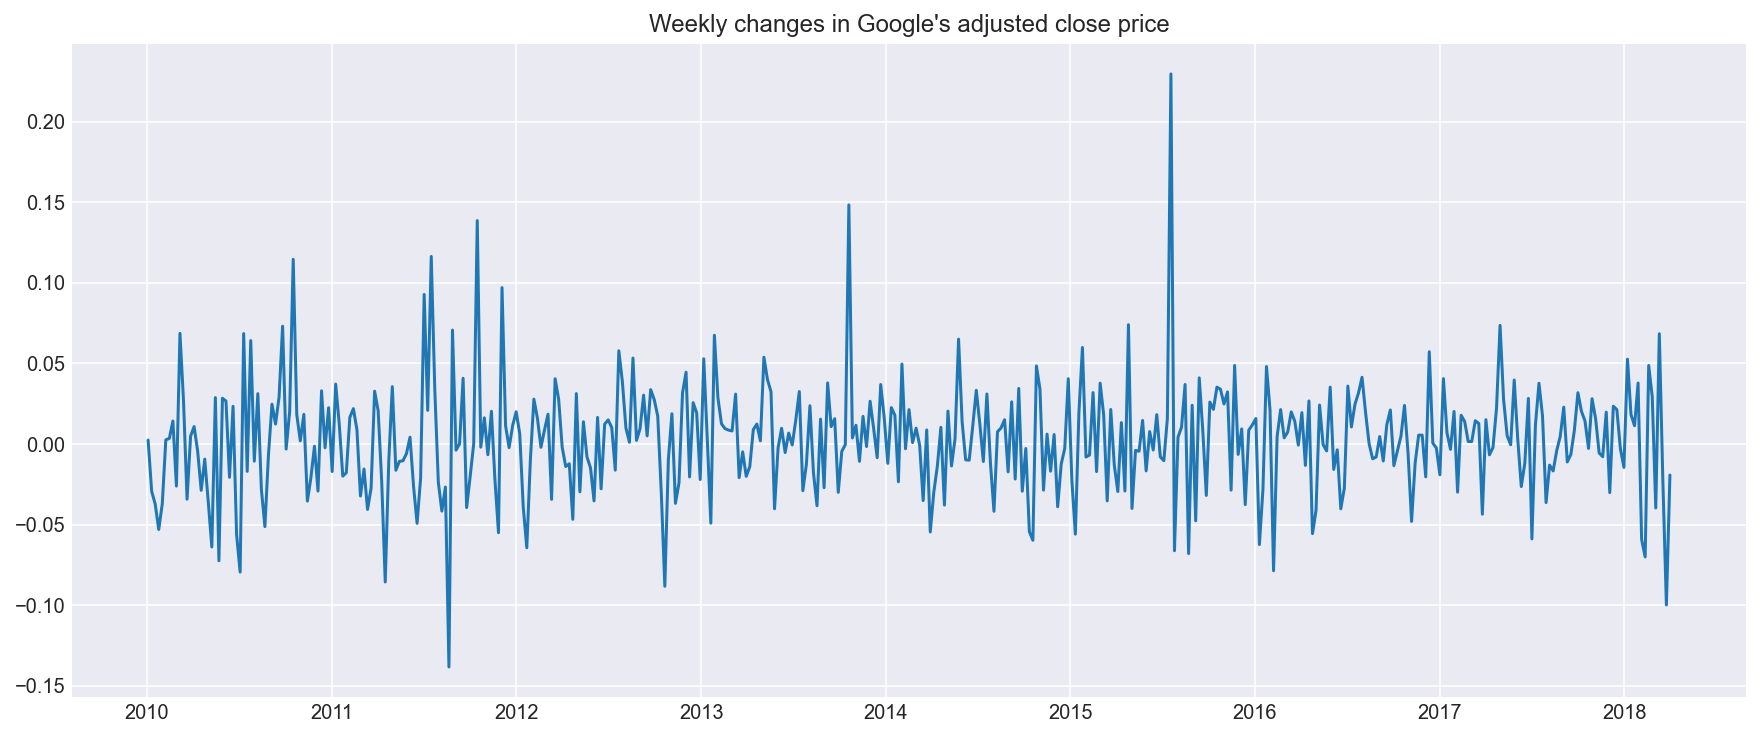

In [4]:
_, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(googl['dl_ac'])
ax.set_title("Weekly changes in Google's adjusted close price");

In [5]:
T = googl.shape[0]
y = np.asarray(googl['dl_ac'])*100

Test recurrent function that generates f and xi

In [6]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfd = tfp.distributions
tfb = tfp.bijectors

In [7]:
dtype = np.float64  # <== need high numerical precision, otherwise risk of nan in log_prob 

eta0 = np.random.rand(100, 2).astype(dtype)

P = np.asarray([[.75, .25], [.25, .75]], dtype=dtype)
xi_ = tf.constant(.75, dtype=dtype)
xi_out = tf.constant(.75, dtype=dtype)

def ft_xit_dt_batch(ft, xi, Eta, P):
  xit0 = tf.stack([xi, 1.-xi], axis=-1)[..., tf.newaxis]
  ft = tf.reduce_sum(
      tf.matmul(xit0 * P, Eta[..., tf.newaxis]), axis=[-2, -1])
  xi1 = (P[..., 0, 0] * xi + P[..., 1, 0] * (1 - xi)) * Eta[..., 0] / ft
  return ft, xi1

# ft_xit_dt(ft_out, xi_out, eta_[0], P)

ft1, xi1 = tf.scan(
    lambda arg, eta: ft_xit_dt_batch(arg[0], arg[1], eta, P),
    eta0,
    (tf.constant(0., dtype=dtype), xi_out))

In [8]:
ft2 = np.zeros(100)
xi2 = np.zeros(100)

ftfunc = lambda eta, xi: P[0, 0]*xi*eta[0] +\
                         P[0, 1]*xi*eta[1] +\
                         P[1, 1]*(1 - xi)*eta[1] +\
                         P[1, 0]*(1 - xi)*eta[0]
Eta = eta0[0]
Xi_ = np.asarray([.75])
ft2[0] = ftfunc(Eta, Xi_)
xi2[0] = (P[0, 0] * Xi_ + P[1, 0] * (1 - Xi_)) * Eta[0] / ft2[0]


for i in range(1, 100):
  Eta = eta0[i]
  Xi_ = xi2[i - 1]
  ft2[i] = ftfunc(Eta, Xi_)
  xi2[i] = (P[0, 0] * Xi_ + P[1, 0] * (1 - Xi_)) * Eta[0] / ft2[i]

In [9]:
np.testing.assert_almost_equal(ft1, ft2)
np.testing.assert_almost_equal(xi1, xi2)

The scan function is fine, to the next step:

Random walk with Markov transition

In [10]:
y_tf = tf.cast(y, dtype=dtype)
n_timepoint = y_tf.shape[0]

In [11]:
prior = tfd.JointDistributionSequentialAutoBatched([
  tfd.Sample(
      tfd.Beta(
          concentration1=tf.cast(10., dtype=dtype),
          concentration0=tf.cast(2., dtype=dtype)
      ), sample_shape=2, name='p'),
  tfd.Sample(
      tfd.Normal(
          loc=tf.cast(0., dtype=dtype),
          scale=tf.cast(.1, dtype=dtype)
      ), sample_shape=2, name='alpha'),
  tfd.Sample(
      tfd.HalfCauchy(
          loc=tf.cast(0., dtype=dtype),
          scale=tf.cast(1., dtype=dtype)
      ), sample_shape=2, name='sigma'),
  tfd.Normal(
      loc=tf.cast(0., dtype=dtype),
      scale=tf.cast(.1, dtype=dtype),
      name='y_tm1_init'
  ),
  tfd.TruncatedNormal(
      loc=tf.cast(1., dtype=dtype),
      scale=tf.cast(.1, dtype=dtype),
      low=0., high=10.,
      name='rho'
  ),
  tfd.Beta(
      concentration1=tf.cast(2., dtype=dtype),
      concentration0=tf.cast(2., dtype=dtype),
      name='xi_init'
  )
])

@tf.function
def build_time_series(p, alpha, sigma, y_tm1_init, rho, xi_init):
  P = tf.linalg.diag(p)
  P = tf.linalg.set_diag(P, 1 - p[..., 0, tf.newaxis], k=1)
  P = tf.linalg.set_diag(P, 1 - p[..., 1, tf.newaxis], k=-1)

  eta1 = tfd.Normal(loc=alpha[..., 0], scale=sigma[..., 0]).prob(
      y_tf[..., tf.newaxis])

  eta2_0 = tfd.Normal(
      loc=alpha[..., 1] + rho * y_tm1_init,
      scale=sigma[..., 1]
  ).prob(y_tf[0])
  eta2_1 = tfd.Normal(
      loc=(alpha[..., 1]
            + rho * y_tf[:-1, tf.newaxis]),
      scale=sigma[..., 1]
  ).prob(y_tf[1:, tf.newaxis])
  eta2 = tf.concat([eta2_0[tf.newaxis, ...], tf.squeeze(eta2_1)], axis=0)

  eta = tf.stack([tf.squeeze(eta1), eta2], axis=-1)

  return tf.scan(
      lambda arg, eta: ft_xit_dt_batch(arg[0], arg[1], eta, P),
      eta,
      (tf.zeros_like(xi_init), xi_init))


p, alpha, sigma, y_tm1_init, rho, xi_init = prior.sample(5)
ft, xi = build_time_series(p, alpha, sigma, y_tm1_init, rho, xi_init)

In [12]:
def likelihood_fn(p, alpha, sigma, y_tm1_init, rho, xi_init):
  P = tf.linalg.diag(p)
  P = tf.linalg.set_diag(P, 1 - p[..., 0, tf.newaxis], k=1)
  P = tf.linalg.set_diag(P, 1 - p[..., 1, tf.newaxis], k=-1)

  eta1 = tfd.Normal(loc=alpha[..., 0], scale=sigma[..., 0]).prob(
      y_tf[..., tf.newaxis])

  eta2_0 = tfd.Normal(
      loc=alpha[..., 1] + rho * y_tm1_init,
      scale=sigma[..., 1]
  ).prob(y_tf[0])
  eta2_1 = tfd.Normal(
      loc=(alpha[..., 1]
            + rho * y_tf[:-1, tf.newaxis]),
      scale=sigma[..., 1]
  ).prob(y_tf[1:, tf.newaxis])
  eta2 = tf.concat([eta2_0[tf.newaxis, ...], eta2_1], axis=0)

  eta = tf.stack([eta1, eta2], axis=-1)

  def ft_xit_dt_batch2(i, ft0, xi):
    eta_i = tf.gather(eta, i, axis=0)
    xit0 = tf.stack([xi, 1.-xi], axis=-1)[..., tf.newaxis]
    ft1 = tf.reduce_sum(
        tf.matmul(xit0 * P, eta_i[..., tf.newaxis]), axis=[-2, -1])
    xi1 = (P[..., 0, 0] * xi + P[..., 1, 0] * (1 - xi)) * eta_i[..., 0] / ft1
    return i+1, ft0 + tf.math.log(ft1), xi1

  _, ft_sum, xi = tf.while_loop(
      cond=lambda i, *args: i < n_timepoint,
      body=ft_xit_dt_batch2,
      loop_vars=(
          tf.constant(0),
          tf.zeros_like(xi_init),
          xi_init
          ),
      maximum_iterations=n_timepoint,
      )

  return ft_sum

In [13]:
target_log_prob_fn = lambda *args: prior.log_prob(*args) + likelihood_fn(*args)

init_position = list(prior.sample(25))
init_position[2] = tf.ones_like(init_position[2]) * tf.cast([[3., 10.]], dtype)
init_position[-2] = tf.ones_like(init_position[-2])
init_position[-4] = tf.ones_like(init_position[-4])
np.alltrue(np.isfinite(target_log_prob_fn(*init_position)))

True

In [14]:
tf.function(target_log_prob_fn, experimental_compile=True)(*prior.sample(25))
tf.function(likelihood_fn, experimental_compile=True)(*prior.sample(1))

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1806.74534564])>

In [15]:
prior_samples = prior.sample(5000)

unconstraining_bijectors = [
    tfb.Sigmoid(),
    tfb.Identity(),
    tfb.Softplus(),
    tfb.Identity(),
    tfb.Softplus(),
    tfb.Sigmoid()
]

init_state = [
  tf.constant([[0.8333333, 0.8333333]], dtype=dtype),
  tf.constant([[0., 0.]], dtype=dtype),
  tf.constant([[1., 1.]], dtype=dtype),
  tf.constant([0.], dtype=dtype),
  tf.constant([1.], dtype=dtype),
  tf.constant([0.5], dtype=dtype)
  ]

In [16]:
#@title window_tune_nuts_sampling
# Copyright 2020 The TensorFlow Probability Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""MCMC sampling with HMC/NUTS using an expanding epoch tuning."""

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.internal import assert_util
from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.internal import tensorshape_util
from tensorflow_probability.python.mcmc.transformed_kernel import make_transform_fn
from tensorflow_probability.python.mcmc.transformed_kernel import make_transformed_log_prob

tfb = tfp.bijectors

__all__ = [
    'window_tune_nuts_sampling',
]


def _sample_posterior(target_log_prob_unbounded,
                      prior_samples_unbounded,
                      init_state=None,
                      num_samples=500,
                      nchains=4,
                      init_nchains=1,
                      target_accept_prob=.8,
                      max_tree_depth=9,
                      use_scaled_init=True,
                      tuning_window_schedule=(75, 25, 25, 25, 25, 25, 50),
                      use_wide_window_expanding_mode=True,
                      seed=None,
                      experimental_compile=True,
                      use_input_signature=True,
                      experimental_relax_shapes=False):
  """MCMC sampling with HMC/NUTS using an expanding epoch tuning."""
  if seed:
    parallel_iterations = 1
  else:
    parallel_iterations = 10

  seed_stream = tfp.util.SeedStream(seed, 'window_tune_nuts_sampling')
  rv_rank = ps.rank(prior_samples_unbounded)
  assert rv_rank == 2
  total_ndims = ps.shape(prior_samples_unbounded)[-1]
  dtype = prior_samples_unbounded.dtype

  # Start with Identity Covariance matrix
  loc_conditioner = tf.Variable(
      tf.zeros([total_ndims], dtype=dtype), name='loc_conditioner')
  scale_conditioner = tf.Variable(
      tf.ones([total_ndims], dtype=dtype), name='scale_conditioner')

  scale = tf.linalg.LinearOperatorDiag(
      diag=scale_conditioner,
      is_non_singular=True,
      is_self_adjoint=True,
      is_positive_definite=True)
  conditioning_bijector = tfb.Shift(shift=loc_conditioner)(
      tfb.ScaleMatvecLinearOperator(scale))

  if init_state is None:
    # Start at uniform random [-1, 1] around the prior mean in latent space
    init_state_uniform = tf.random.uniform(
        [init_nchains, total_ndims], dtype=dtype, seed=seed_stream()) * 2. - 1.
    if use_scaled_init:
      prior_z_mean = tf.math.reduce_mean(prior_samples_unbounded, axis=0)
      prior_z_std = tf.math.reduce_std(prior_samples_unbounded, axis=0)
      init_state = init_state_uniform * prior_z_std + prior_z_mean
    else:
      init_state = init_state_uniform

  init_step_size = tf.constant(0.25 / (total_ndims**0.25), dtype=dtype)

  hmc_inner = tfp.mcmc.TransformedTransitionKernel(
      tfp.mcmc.NoUTurnSampler(
          target_log_prob_fn=target_log_prob_unbounded,
          step_size=init_step_size,
          max_tree_depth=max_tree_depth,
          seed=seed_stream,
          parallel_iterations=parallel_iterations,
      ), conditioning_bijector)

  hmc_step_size_tuning = tfp.mcmc.DualAveragingStepSizeAdaptation(
      hmc_inner,
      max(tuning_window_schedule),
      target_accept_prob=target_accept_prob)

  if use_input_signature:
    input_signature = [
        tf.TensorSpec(shape=None, dtype=tf.int32),
        tf.TensorSpec(shape=[None, total_ndims], dtype=dtype),
    ]
  else:
    input_signature = None

  @tf.function(
      input_signature=input_signature,
      autograph=False,
      experimental_compile=experimental_compile,
      experimental_relax_shapes=experimental_relax_shapes)
  def fast_adaptation_interval(num_steps, current_state):

    def body_fn(i, state, pkr):
      next_state, next_pkr = hmc_step_size_tuning.one_step(state, pkr)
      return i + 1, next_state, next_pkr

    current_pkr = hmc_step_size_tuning.bootstrap_results(current_state)
    return tf.while_loop(
        lambda i, *_: i < num_steps,
        body_fn,
        loop_vars=(0, current_state, current_pkr),
        maximum_iterations=num_steps,
        parallel_iterations=parallel_iterations)

  def body_fn_window2(
      i, previous_state, previous_pkr, previous_mean, previous_cov):
    next_state, next_pkr = hmc_step_size_tuning.one_step(
        previous_state, previous_pkr)
    n_next = i + 1
    delta_pre = previous_state - previous_mean
    next_mean = previous_mean + delta_pre / tf.cast(n_next, delta_pre.dtype)
    delta_post = previous_state - next_mean
    delta_cov = tf.expand_dims(delta_post, -1) * tf.expand_dims(delta_pre, -2)
    next_cov = previous_cov + delta_cov

    next_mean.set_shape(previous_mean.shape)
    next_cov.set_shape(previous_cov.shape)
    return n_next, next_state, next_pkr, next_mean, next_cov

  if use_input_signature:
    input_signature = [
        tf.TensorSpec(shape=None, dtype=tf.int32),
        tf.TensorSpec(shape=None, dtype=tf.int32),
        tf.TensorSpec(shape=[None, total_ndims], dtype=dtype),
        tf.TensorSpec(shape=[None, total_ndims], dtype=dtype),
        tf.TensorSpec(shape=[None, total_ndims, total_ndims], dtype=dtype),
    ]
  else:
    input_signature = None

  @tf.function(
      input_signature=input_signature,
      autograph=False,
      experimental_compile=experimental_compile,
      experimental_relax_shapes=experimental_relax_shapes)
  def slow_adaptation_interval(num_steps, last_n, previous_state, previous_mean,
                               previous_cov):
    previous_pkr = hmc_step_size_tuning.bootstrap_results(previous_state)
    total_n, next_state, next_pkr, next_mean, next_cov = tf.while_loop(
        lambda i, *_: i < num_steps + last_n,
        body_fn_window2,
        loop_vars=(last_n, previous_state, previous_pkr, previous_mean,
                   previous_cov),
        maximum_iterations=num_steps,
        parallel_iterations=parallel_iterations)
    float_n = tf.cast(total_n, next_cov.dtype)
    cov = next_cov / (float_n - 1.)

    # Regularization
    scaled_cov = (float_n / (float_n + 5.)) * cov
    shrinkage = 1e-3 * (5. / (float_n + 5.))
    next_cov = scaled_cov + shrinkage

    return total_n, next_state, next_pkr, next_mean, next_cov

  def trace_fn(_, pkr):
    return (
        pkr.inner_results.target_log_prob,
        pkr.inner_results.leapfrogs_taken,
        pkr.inner_results.has_divergence,
        pkr.inner_results.energy,
        pkr.inner_results.log_accept_ratio,
        pkr.inner_results.reach_max_depth,
        pkr.inner_results.step_size,
    )

  @tf.function(autograph=False, experimental_compile=experimental_compile)
  def run_chain(num_results, current_state, previous_kernel_results):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=0,
        current_state=current_state,
        previous_kernel_results=previous_kernel_results,
        kernel=hmc_inner,
        trace_fn=trace_fn,
        parallel_iterations=parallel_iterations)

  # Main sampling with tuning routine.
  num_steps_tuning_window_schedule0 = tuning_window_schedule[0]

  # Window 1 to tune step size
  print('Tuning Window 1...')
  i, next_state, _ = fast_adaptation_interval(num_steps_tuning_window_schedule0,
                                              init_state)

  next_mean = tf.zeros_like(init_state)
  next_cov = tf.zeros(
      ps.concat([ps.shape(init_state), ps.shape(init_state)[-1:]], axis=-1),
      dtype=dtype)

  mean_updater = tf.zeros([total_ndims], dtype=dtype)
  diag_updater = tf.ones([total_ndims], dtype=dtype)

  # Window 2 to tune mass matrix.
  total_n = 0
  for i, num_steps in enumerate(tuning_window_schedule[1:-1]):
    print(f'Tuning Window 2 - {i}...')
    if not use_wide_window_expanding_mode:
      num_steps = num_steps * 2**i
    with tf.control_dependencies([
        loc_conditioner.assign(mean_updater, read_value=False),
        scale_conditioner.assign(diag_updater, read_value=False)
    ]):
      (total_n, next_state_, _, next_mean_,
       next_cov_) = slow_adaptation_interval(num_steps, total_n, next_state,
                                             next_mean, next_cov)
      diag_part = tf.linalg.diag_part(next_cov_)
      if ps.rank(next_state) > 1:
        mean_updater = tf.reduce_mean(next_mean_, axis=0)
        diag_updater = tf.math.sqrt(tf.reduce_mean(diag_part, axis=0))
      else:
        mean_updater = next_mean_
        diag_updater = tf.math.sqrt(diag_part)

      if use_wide_window_expanding_mode:
        next_mean = tf.concat([next_mean_, next_mean_], axis=0)
        next_cov = tf.concat([next_cov_, next_cov_], axis=0)
        next_state = tf.concat([next_state_, next_state_], axis=0)
      else:
        next_mean, next_cov, next_state = next_mean_, next_cov_, next_state_

  num_steps_tuning_window_schedule3 = tuning_window_schedule[-1]
  num_batches = ps.size0(next_state)
  if nchains > num_batches:
    final_init_state = tf.repeat(
        next_state, (nchains + 1) // num_batches, axis=0)[:nchains]
  else:
    final_init_state = next_state[:nchains]

  with tf.control_dependencies([
      loc_conditioner.assign(mean_updater, read_value=False),
      scale_conditioner.assign(diag_updater, read_value=False)
  ]):
    # Window 3 step size tuning
    print('Tuning Window 3...')
    i, final_tuned_state, final_pkr = fast_adaptation_interval(
        num_steps_tuning_window_schedule3, final_init_state)

    # Final samples
    print('Sampling...')
    nuts_samples, diagnostic = run_chain(num_samples, final_tuned_state,
                                         final_pkr.inner_results)

  return nuts_samples, diagnostic, conditioning_bijector


def window_tune_nuts_sampling(target_log_prob,
                              prior_samples,
                              constraining_bijectors=None,
                              init_state=None,
                              num_samples=500,
                              nchains=4,
                              init_nchains=1,
                              target_accept_prob=.8,
                              max_tree_depth=9,
                              use_scaled_init=True,
                              tuning_window_schedule=(
                                  75, 25, 25, 25, 25, 25, 50),
                              use_wide_window_expanding_mode=True,
                              seed=None,
                              experimental_compile=True,
                              use_input_signature=True,
                              experimental_relax_shapes=False):
  """Sample from a density function with NUTS and an expanding window tuning.

  This function implements a turnkey MCMC sampling routine using NUTS and an
  expanding window tuning strategy similar to Stan [1]. It learns a pre-
  conditioner that scales and rotates the target distribution using a series of
  expanding window - either in number of sample (same as in Stan,
  use_wide_window_expanding_mode=False) or in number of batches/chains (
  use_wide_window_expanding_mode=True).

  Internally, it calls `_sample_posterior` that assuming a real-valued target
  density function and takes a Tensor with shape=(batch * dimension) as input.
  The tuning routine is a memory-less (i.e., no warm-up samples are saved) MCMC
  sampling with number of samples specified by a list-like
  `tuning_window_schedule`.

  Args:
    target_log_prob: Python callable which takes an argument like
      `current_state` (or `*current_state` if it's a list) and returns its
      (possibly unnormalized) log-density under the target distribution.
    prior_samples: Nested structure of `Tensor`s, each of shape `[batches,
      latent_part_event_shape]` and should be sample from the prior. They are
      used to generate an inital chain position if `init_state` is not supplied.
    constraining_bijectors: `tfp.distributions.Bijector` or list of
      `tfp.distributions.Bijector`s. These bijectors use `forward` to map the
      state on the real space to the constrained state expected by
      `target_log_prob`.
    init_state: (Optional) `Tensor` or Python `list` of `Tensor`s representing
      the inital state(s) of the Markov chain(s).
    num_samples: Integer number of the Markov chain draws after tuning.
    nchains: Integer number of the Markov chains after tuning.
    init_nchains: Integer number of the Markov chains in the initial tuning.
    target_accept_prob: Floating point scalar `Tensor`. Target accept
      probability.
    max_tree_depth: Maximum depth of the tree implicitly built by NUTS.
    use_scaled_init: Boolean. If `True`, generate inital state within [-1, 1]
      scaled by prior sample standard deviation in the unconstrained real space.
      This kwarg is ignored if `init_state` is not None
    tuning_window_schedule: List-like sequence of integers that specify the
      tuning schedule. Each integer number specifies the number of MCMC samples
      within a single warm-up window. The first and the last window tunes the
      step size (a scaler) only, while the intermedia windows tune both step
      size and the pre-conditioner. More over, the intermedia windows takes
      number of samples double in size: for example, the default schedule (75,
        25, 25, 25, 25, 25, 50) actually means it will take (75, 25 * 2**0, 25 *
        2**1, 25 * 2**2, 25 * 2**2, 25 * 2**3, 50) samples.
    use_wide_window_expanding_mode: Boolean. Default to `True` that we double
      the number of chains from the previous stage for the intermedia windows.
    seed: Python integer to seed the random number generator.
    experimental_compile: kwarg pass to tf.function decorator. If True, the
      function is always compiled by XLA.
    use_input_signature: If True, generate an input_signature kwarg that pass to
      tf.function decorator.
    experimental_relax_shapes: kwarg pass to tf.function decorator. When True,
      tf.function may generate fewer, graphs that are less specialized on input
      shapes.

  Returns:
    posterior_samples: A `Tensor` or Python list of `Tensor`s representing the
      posterior MCMC samples after tuning. The leading shape is (num_samples *
      nchains)
    diagnostic: A list of `Tensor` representing the diagnositc from NUTS:
      `target_log_prob`, `leapfrogs_taken`, `has_divergence`, `energy`,
      `log_accept_ratio`, `reach_max_depth`, `step_size.
    conditioning_bijector: A tfp bijector that scales and rotates the target
      density function in latent unbounded space.

  ### Examples

  Sampling from a multivariate Student-T distribution.

  ```python
  DTYPE = np.float32

  nd = 50
  concentration = 1.

  prior_dist = tfd.Sample(tfd.Normal(tf.constant(0., DTYPE), 100.), nd)

  mu = tf.cast(np.linspace(-100, 100, nd), dtype=DTYPE)
  sigma = tf.cast(np.exp(np.linspace(-1, 1.5, nd)), dtype=DTYPE)
  corr_tril = tfd.CholeskyLKJ(
      dimension=nd, concentration=concentration).sample()
  scale_tril = tf.linalg.matmul(tf.linalg.diag(sigma), corr_tril)
  target_dist = tfd.MultivariateStudentTLinearOperator(
      df=5., loc=mu, scale=tf.linalg.LinearOperatorLowerTriangular(scale_tril))

  target_log_prob = lambda *x: (
      prior_dist.log_prob(*x) + target_dist.log_prob(*x))

  (
      [mcmc_samples], diagnostic, conditioning_bijector
  ) = window_tune_nuts_sampling(target_log_prob, [prior_dist.sample(2000)])

  loc_conditioner, scale_conditioner = conditioning_bijector.trainable_variables

  _, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].plot(mu, loc_conditioner.numpy(), 'o', label='conditioner mean')
  ax[0].plot(mu, tf.reduce_mean(
      mcmc_samples, axis=[0, 1]), 'o', label='estimated mean')
  ax[0].legend()

  sigma_sim = np.std(target_dist.sample(10000), axis=0)
  ax[1].plot(sigma_sim, scale_conditioner.numpy(), 'o', label='conditioner std')
  ax[1].plot(sigma_sim, tf.math.reduce_std(
      mcmc_samples, axis=[0, 1]), 'o', label='estimated std');
  ax[1].legend()

  ax[0].plot([min(mu), max(mu)], [min(mu), max(mu)])
  ax[1].plot([min(sigma_sim), max(sigma_sim)], [min(sigma_sim), max(sigma_sim)])
  ```

  #### References

  [1]: Stan Reference Manual.
  https://mc-stan.org/docs/2_23/reference-manual/hmc-algorithm-parameters.html#automatic-parameter-tuning
  """

  log_prob_val = target_log_prob(*prior_samples)
  log_prob_rank = ps.rank(log_prob_val)
  assert log_prob_rank == 1

  if constraining_bijectors is not None:
    target_log_prob_unbounded = make_transformed_log_prob(
        target_log_prob,
        constraining_bijectors,
        direction='forward',
        enable_bijector_caching=False)
    # bound to unbound
    inverse_transform = make_transform_fn(constraining_bijectors, 'inverse')
    # unbound to bound
    forward_transform = make_transform_fn(constraining_bijectors, 'forward')
  else:
    target_log_prob_unbounded = target_log_prob
    inverse_transform = lambda x: x
    forward_transform = lambda y: y

  prior_samples_unbounded = inverse_transform(prior_samples)
  init_state_unbounded = None

  if tf.nest.is_nested(prior_samples_unbounded):
    free_rv_event_shape = [x.shape[log_prob_rank:] for x in prior_samples]
    flat_event_splits = [s.num_elements() for s in free_rv_event_shape]

    # TODO(junpenglao): replace the two function below with `tfb.Split`.
    def split_and_reshape(x):
      assertions = []
      message = 'Input must have at least one dimension.'
      if tensorshape_util.rank(x.shape) is not None:
        if tensorshape_util.rank(x.shape) == 0:
          raise ValueError(message)
      else:
        assertions.append(
            assert_util.assert_rank_at_least(x, 1, message=message))
      with tf.control_dependencies(assertions):
        x = tf.nest.pack_sequence_as(free_rv_event_shape,
                                     tf.split(x, flat_event_splits, axis=-1))

        def _reshape_map_part(part, event_shape):
          static_rank = tf.get_static_value(ps.rank_from_shape(event_shape))
          if static_rank == 1:
            return part
          new_shape = ps.concat([ps.shape(part)[:-1], event_shape], axis=-1)
          return tf.reshape(part, ps.cast(new_shape, tf.int32))

        x = tf.nest.map_structure(_reshape_map_part, x, free_rv_event_shape)
      return x

    def concat_list_event(x):

      def handle_part(x, shape):
        if len(shape) == 0:  # pylint: disable=g-explicit-length-test
          return x[..., tf.newaxis]
        return tf.reshape(x, list(x.shape)[:-len(shape)] + [-1])

      flat_parts = [handle_part(v, s) for v, s in zip(x, free_rv_event_shape)]
      return tf.concat(flat_parts, axis=-1)

    def target_log_prob_unbounded_concated(x):
      x = split_and_reshape(x)
      return target_log_prob_unbounded(*x)

    prior_samples_unbounded_concated = concat_list_event(
        prior_samples_unbounded)
    if init_state is not None:
      init_state_unbounded = concat_list_event(inverse_transform(init_state))
  else:
    target_log_prob_unbounded_concated = target_log_prob_unbounded
    prior_samples_unbounded_concated = prior_samples_unbounded
    split_and_reshape = lambda x: x
    if init_state is not None:
      init_state_unbounded = inverse_transform(init_state)

  nuts_samples, diagnostic, conditioning_bijector = _sample_posterior(
      target_log_prob_unbounded_concated,
      prior_samples_unbounded_concated,
      init_state=init_state_unbounded,
      num_samples=num_samples,
      nchains=nchains,
      init_nchains=init_nchains,
      target_accept_prob=target_accept_prob,
      max_tree_depth=max_tree_depth,
      use_scaled_init=use_scaled_init,
      tuning_window_schedule=tuning_window_schedule,
      use_wide_window_expanding_mode=use_wide_window_expanding_mode,
      seed=seed,
      experimental_compile=experimental_compile,
      use_input_signature=use_input_signature,
      experimental_relax_shapes=experimental_relax_shapes)
  return forward_transform(
      split_and_reshape(nuts_samples)), diagnostic, conditioning_bijector


In [17]:
%%time

nuts_samples, sampler_stats, conditioning_bijector = window_tune_nuts_sampling(
    target_log_prob_fn, prior_samples, unconstraining_bijectors,
    num_samples=1000, init_state=init_state, use_input_signature=False)

Tuning Window 1...
Tuning Window 2 - 0...
Tuning Window 2 - 1...
Tuning Window 2 - 2...
Tuning Window 2 - 3...
Tuning Window 2 - 4...
Tuning Window 3...
Sampling...
CPU times: user 2min 17s, sys: 849 ms, total: 2min 18s
Wall time: 2min 19s


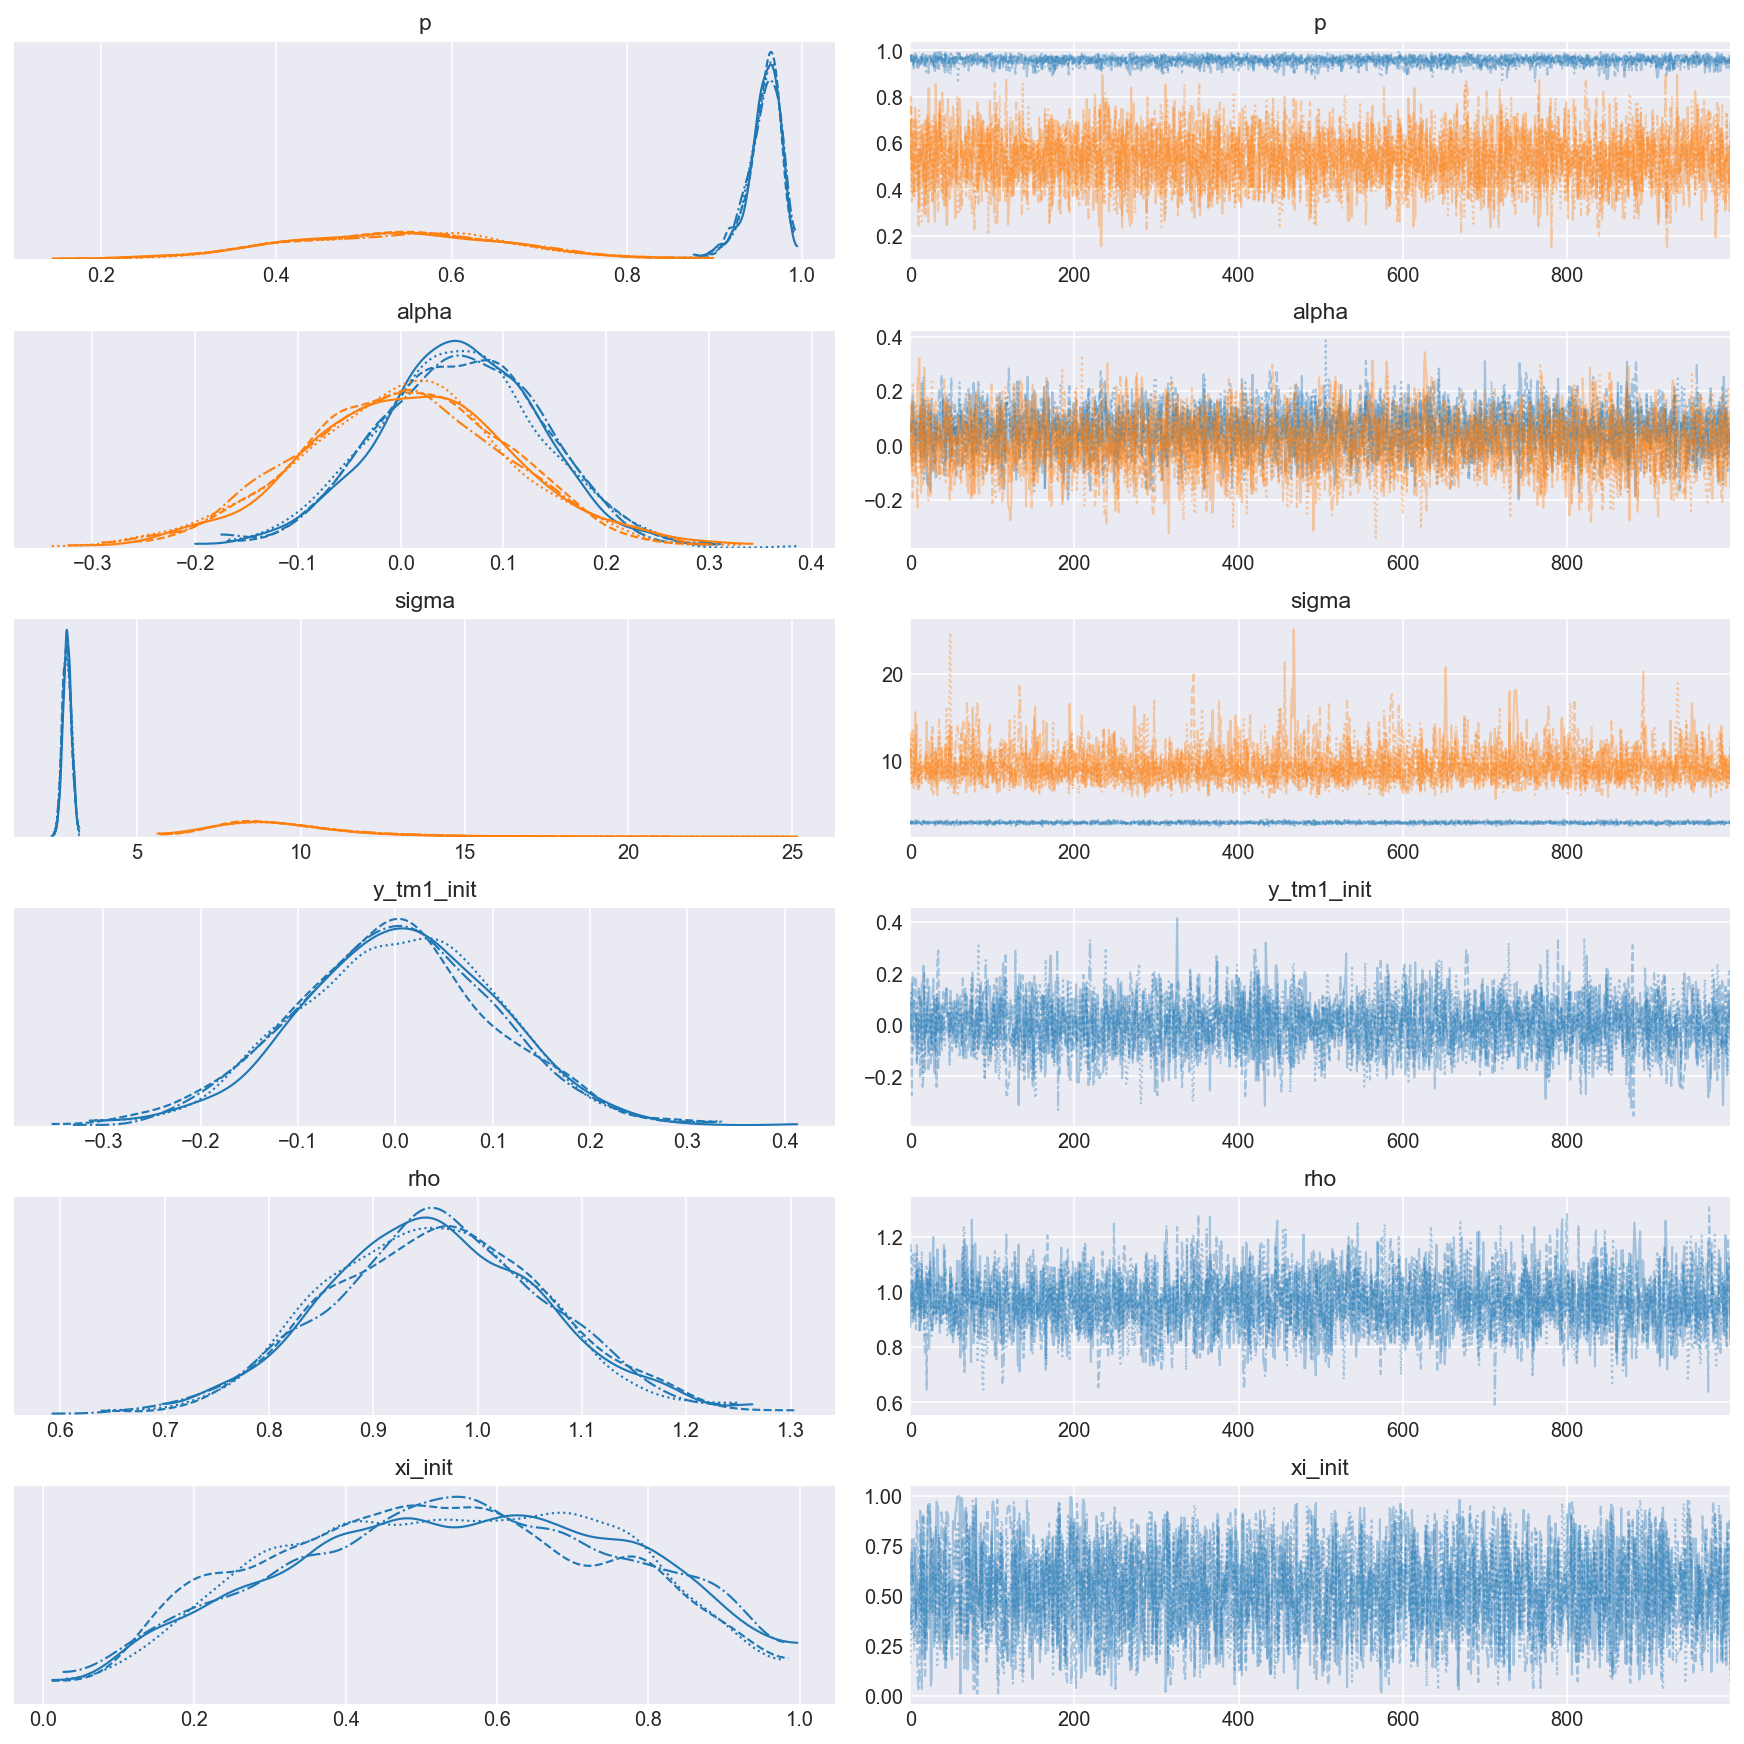

In [18]:
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept', 'reach_max_depth']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stats)}

var_name = ['p', 'alpha', 'sigma', 'y_tm1_init', 'rho', 'xi_init']
posterior = {k:np.swapaxes(v.numpy(), 1, 0)
             for k, v in zip(var_name, nuts_samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)
az.plot_trace(az_trace, compact=True);

In [19]:
df = az.summary(az_trace, var_names=['alpha', 'rho', 'p', 'sigma'])
df.round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.06,0.08,-0.10,0.19,0.00,0.00,3083.0,2252.0,3073.0,2462.0,1.0
alpha[1],0.00,0.10,-0.19,0.19,0.00,0.00,2491.0,1524.0,2486.0,2167.0,1.0
rho,0.96,0.10,0.76,1.15,0.00,0.00,3194.0,3194.0,3182.0,2362.0,1.0
p[0],0.96,0.02,0.92,0.99,0.00,0.00,3429.0,3429.0,3632.0,2673.0,1.0
p[1],0.54,0.12,0.32,0.76,0.00,0.00,4414.0,4342.0,4407.0,2770.0,1.0
sigma[0],2.87,0.13,2.62,3.11,0.00,0.00,4138.0,4138.0,4140.0,3085.0,1.0
sigma[1],9.45,2.04,6.31,13.29,0.04,0.03,2392.0,2078.0,3067.0,2188.0,1.0


Compare with Stan fit:
```
## Inference for Stan model: regime_switching_model.
## 4 chains, each with iter=1000; warmup=500; thin=1; 
## post-warmup draws per chain=500, total post-warmup draws=2000.
## 
##          mean se_mean   sd  2.5%   25%  50%   75% 97.5% n_eff Rhat
## alpha[1] 0.06    0.00 0.08 -0.10  0.00 0.06  0.11  0.21  2000    1
## alpha[2] 0.01    0.00 0.10 -0.20 -0.06 0.01  0.07  0.21  2000    1
## rho      0.96    0.00 0.10  0.76  0.89 0.96  1.03  1.16  2000    1
## p[1]     0.96    0.00 0.02  0.92  0.95 0.96  0.97  0.99  2000    1
## p[2]     0.54    0.00 0.12  0.31  0.46 0.55  0.63  0.77  2000    1
## sigma[1] 2.85    0.00 0.13  2.59  2.77 2.85  2.94  3.10  2000    1
## sigma[2] 9.69    0.06 2.26  6.56  8.15 9.24 10.76 15.31  1672    1
## 
## Samples were drawn using NUTS(diag_e) at Wed Feb 28 11:22:52 2018.
## For each parameter, n_eff is a crude measure of effective sample size,
## and Rhat is the potential scale reduction factor on split chains (at 
## convergence, Rhat=1).
```

In [21]:
posterior_val = [
  np.reshape(np.swapaxes(v.numpy(), 1, 0), [1000*4, -1]).squeeze()
  for v in nuts_samples]
[v.shape for v in posterior_val]
_, xi_post = build_time_series(*posterior_val)

In [22]:
xilo, xihi = np.percentile(xi_post, [2.5, 97.5], axis=-1)
googl = (googl.assign(xipost = np.mean(xi_post, axis=-1))
              .assign(xilower = xilo)
              .assign(xihigher = xihi)
        )

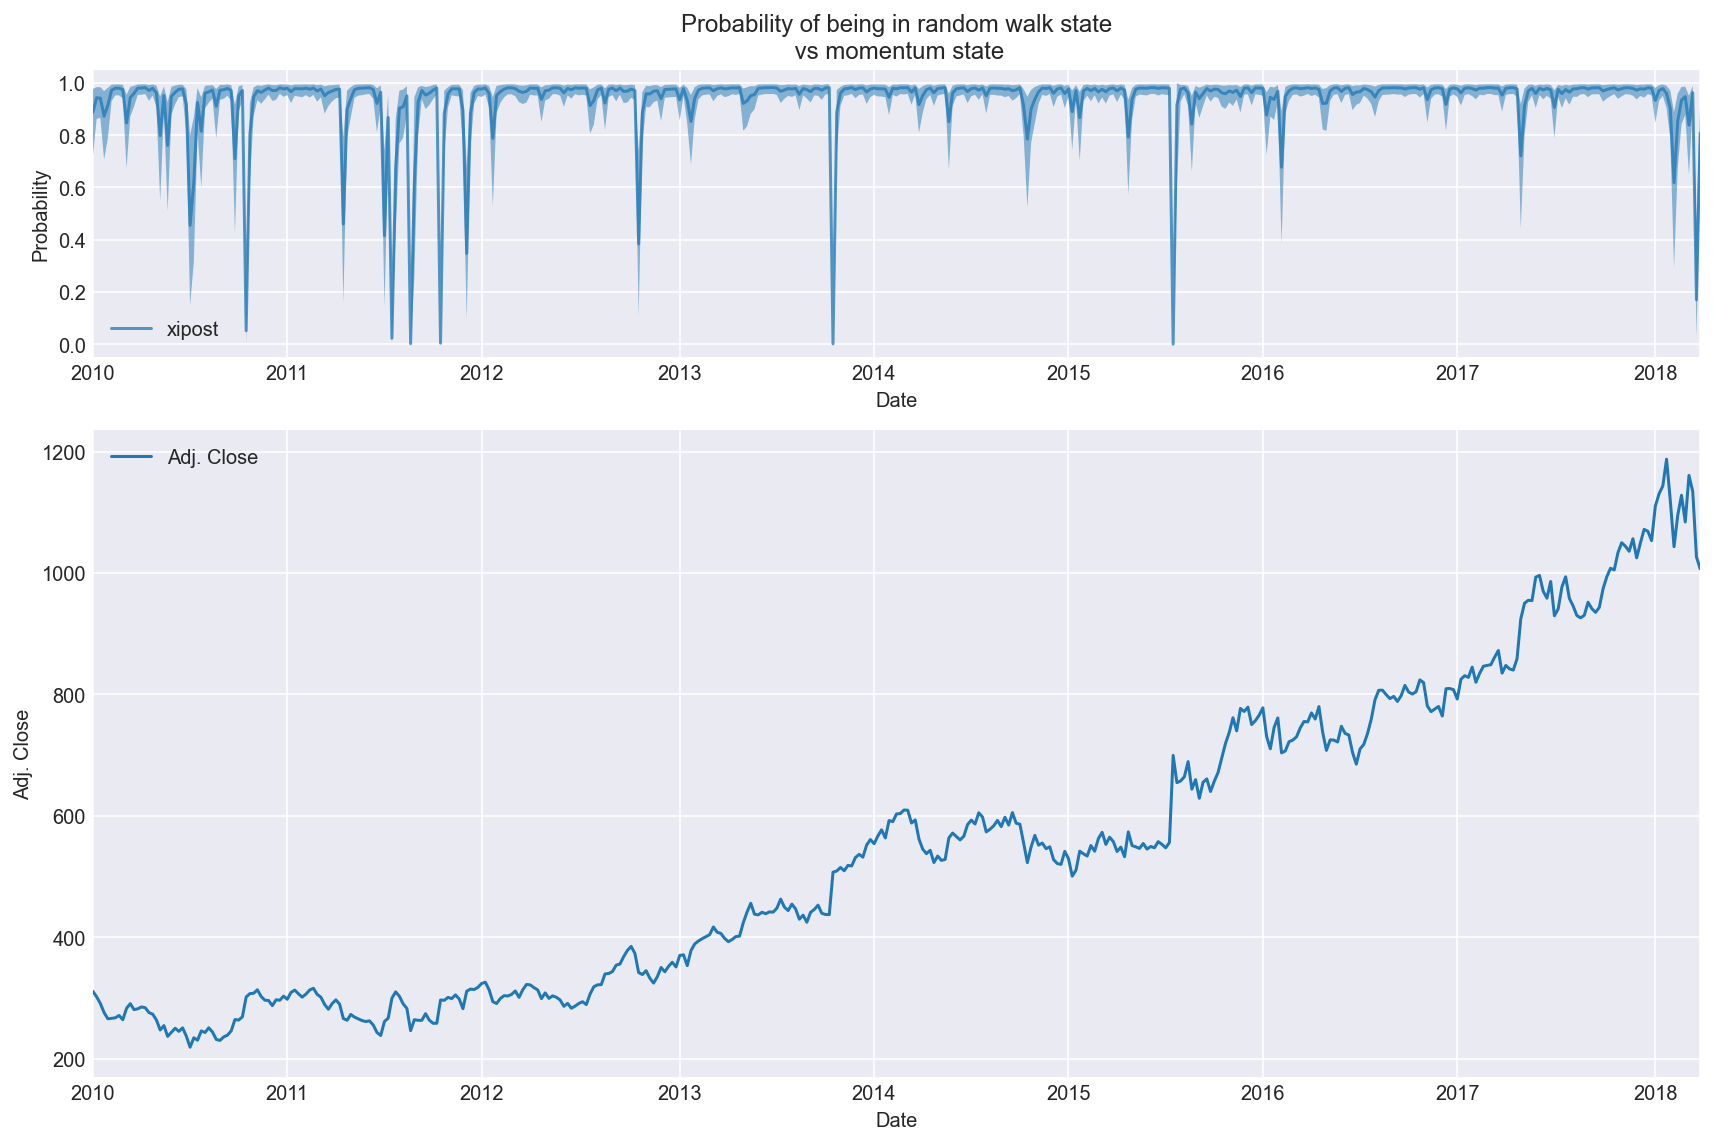

In [23]:
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0), fig=fig)
ax2 = plt.subplot2grid((3, 1), (1, 0), fig=fig, rowspan=2)

googl.plot(y='xipost', alpha=.75, ax=ax1,
           title="Probability of being in random walk state\n vs momentum state")
ax1.fill_between(googl.index, googl.xilower, googl.xihigher, alpha=.5)
ax1.set_ylabel('Probability')
googl.plot(y='Adj. Close', ax=ax2)
ax2.set_ylabel('Adj. Close')
plt.tight_layout();